In [1]:
import itertools
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

#warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA_DIR = '../data'
df = pd.read_excel(DATA_DIR + '/Superstore.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
furniture = df.loc[df.Category == 'Furniture']

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Prep

In [5]:
drops = [
    'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
    'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 
    'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
    'Quantity', 'Discount', 'Profit']
furniture.drop(drops, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
print(furniture.isnull().sum())
furniture.head()

Order Date    0
Sales         0
dtype: int64


/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [6]:
furniture = furniture.set_index('Order Date')
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


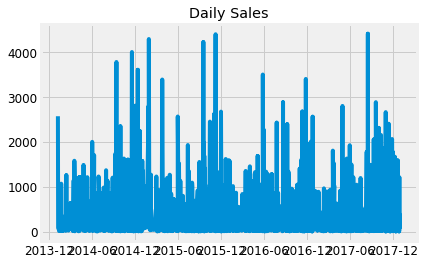

In [7]:
plt.plot(furniture['Sales']);
plt.title('Daily Sales');

In [8]:
# Aggregate to monthly means
y = furniture['Sales'].resample('MS').mean()
y[:10]

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
2014-04-01    305.570654
2014-05-01    288.032792
2014-06-01    440.204187
2014-07-01    327.910636
2014-08-01    305.014437
2014-09-01    425.294300
2014-10-01    384.507719
Freq: MS, Name: Sales, dtype: float64

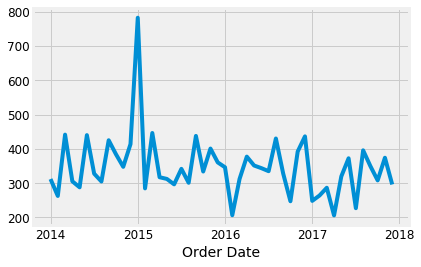

In [9]:
y.plot();

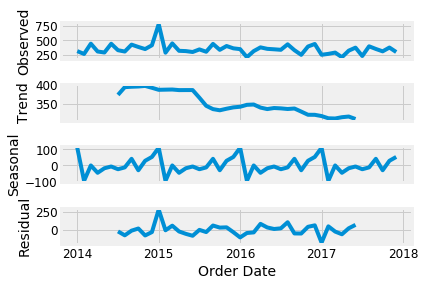

In [10]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

# ARIMA

In [13]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # all combinations of p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [14]:
print('Example param combinations for Seasonal ARIMA:')
print('SARIMA X: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA X: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Example param combinations for Seasonal ARIMA:
SARIMA X: (0, 0, 1) x (0, 0, 1, 12)
SARIMA X: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
min_AIC = np.inf
best_params = [None, None]
best_results = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param, 
                                            seasonal_order=param_seasonal,
                                            enforce_stationary=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_AIC:
                min_AIC = results.aic
                best_params = [param, param_seasonal]
                best_results = results
            #print('ARIMA{}x{}12\tAIC: {}'.format(
            #    param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [17]:
print(min_AIC)
print(best_params)
print(best_results)

442.60811321477064
[(0, 1, 1), (1, 1, 0, 12)]


# Fitting ARIMA model

In [19]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.419     -2.387      0.017      -1.821      -0.179
ar.S.L12       0.0086      0.010      0.856      0.392      -0.011       0.028
sigma2      6235.1880   6.72e-05   9.28e+07      0.000    6235.188    6235.188


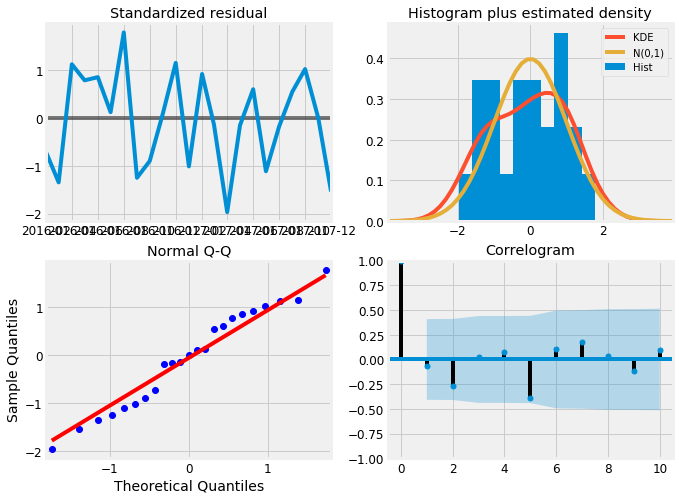

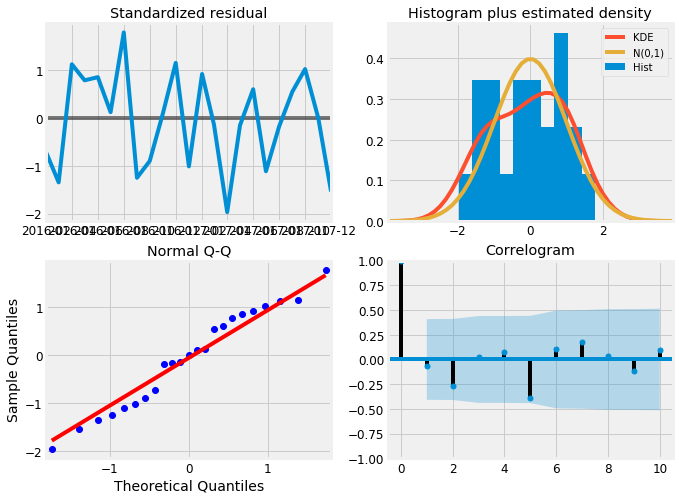

In [21]:
results.plot_diagnostics(figsize=(10, 8))

# Validating Forecasts